# LIGA DE INVERSORES: DESCARGA Y ANÁLISIS DE FONDOS

In [9]:
from google.auth.transport.requests import Request
from google.oauth2 import service_account
from google.cloud import bigquery
from google.auth.exceptions import DefaultCredentialsError
import pandas as pd
import numpy as np
import yfinance as yf
import missingno as mno
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# DESCARGA DE LOS DATOS

Se cargan las credenciales para poder autenticarse.

In [10]:
try:
    # Crear las credenciales a partir del archivo de cuenta de servicio
    credentials = service_account.Credentials.from_service_account_file(
        'credenciales_liga_inversores.json',  # Ruta al archivo JSON que contiene las credenciales
        scopes=["https://www.googleapis.com/auth/bigquery"]  # Ámbito de acceso para BigQuery
    )

    # Refrescar el token de acceso en caso de que haya expirado
    credentials.refresh(Request())  # Refresca el token utilizando una solicitud de autorización
    print("Credenciales cargadas y token refrescado con éxito.")  # Imprime un mensaje de éxito

# Si ocurre un error relacionado con las credenciales, se captura y muestra el error
except DefaultCredentialsError as e:
    print(f"Error de credenciales: {e}")  # Muestra el mensaje de error relacionado con las credenciales

# Si ocurre cualquier otro tipo de error, se captura y muestra el error
except Exception as e:
    print(f"Se produjo un error: {e}")  # Muestra un mensaje general para cualquier otro error


Credenciales cargadas y token refrescado con éxito.


La lista de códigos ISIN (International Securities Identification Number) se genera como una cadena de texto en la que cada código ISIN está entre comillas y separado por comas. Para crearla, debes incluir los códigos ISIN válidos de los activos financieros que estás analizando.

In [11]:
ListaISIN = "'IE00BNQ4RL64','LU0570466788','LU0945454980'"

Este código realiza una consulta en Google BigQuery para obtener datos de valor liquidativo (NAV) de activos financieros identificados por códigos ISIN

In [12]:
# Proyecto en el que se ejecuta.
project = 'ironia-data'

#Creacion  del cliente

client = bigquery.Client(project=project, credentials=credentials)
sql_str = "SELECT * FROM( SELECT date,isin,nav FROM ironia-data.ironia.navs WHERE date BETWEEN '2020-01-01' AND CURRENT_DATE()) PIVOT (MAX(nav) FOR isin IN (" + ListaISIN + ")) ORDER BY Date ASC"


Da formato a los valores y muestra, para cada fondo, cuántos valores válidos (non-null) tiene

In [13]:
datos_fondos = client.query(sql_str).to_dataframe()

datos_fondos = datos_fondos.set_index("date")

datos_fondos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1934 entries, 2020-01-01 to 2025-04-17
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IE00BNQ4RL64  1295 non-null   float64
 1   LU0570466788  1301 non-null   float64
 2   LU0945454980  1309 non-null   float64
dtypes: float64(3)
memory usage: 60.4 KB


Elimina los fondos que no tienen ningún valor válido y luego los días en los que no hay valores válidos. Luego guarda los valores en un fichero excel llamado precios_fondos.xlsx

In [14]:
datos_fondos = datos_fondos.dropna(axis=1, how='all')

datos_fondos = datos_fondos.dropna()

datos_fondos.to_excel('datos_fondos.xlsx',index=False)

Mostrar los datos ya limpios

In [15]:
datos_fondos

,IE00BNQ4RL64,LU0570466788,LU0945454980
date,,,
2020-01-02,14.7316,105.910,104.99
2020-01-03,14.6872,105.920,105.00
2020-01-06,14.6579,105.930,105.01
2020-01-07,14.6417,105.930,105.02
2020-01-08,14.6418,105.930,105.02
...,...,...,...
2025-04-10,19.5158,124.547,119.28
2025-04-11,19.8258,124.504,119.31
2025-04-14,20.1335,124.576,119.33


<Axes: >

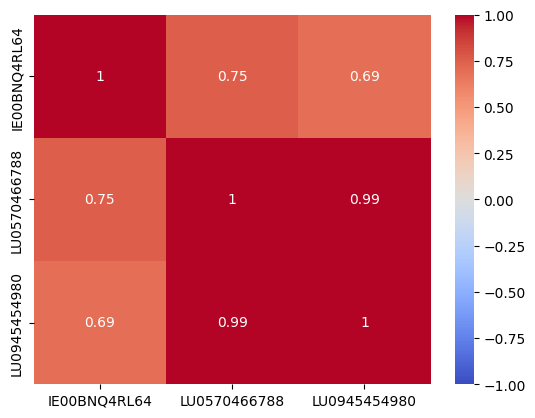

In [16]:
matrix_cor = datos_fondos.corr()

sns.heatmap(matrix_cor, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)

[*********************100%***********************]  3 of 3 completed


<Axes: >

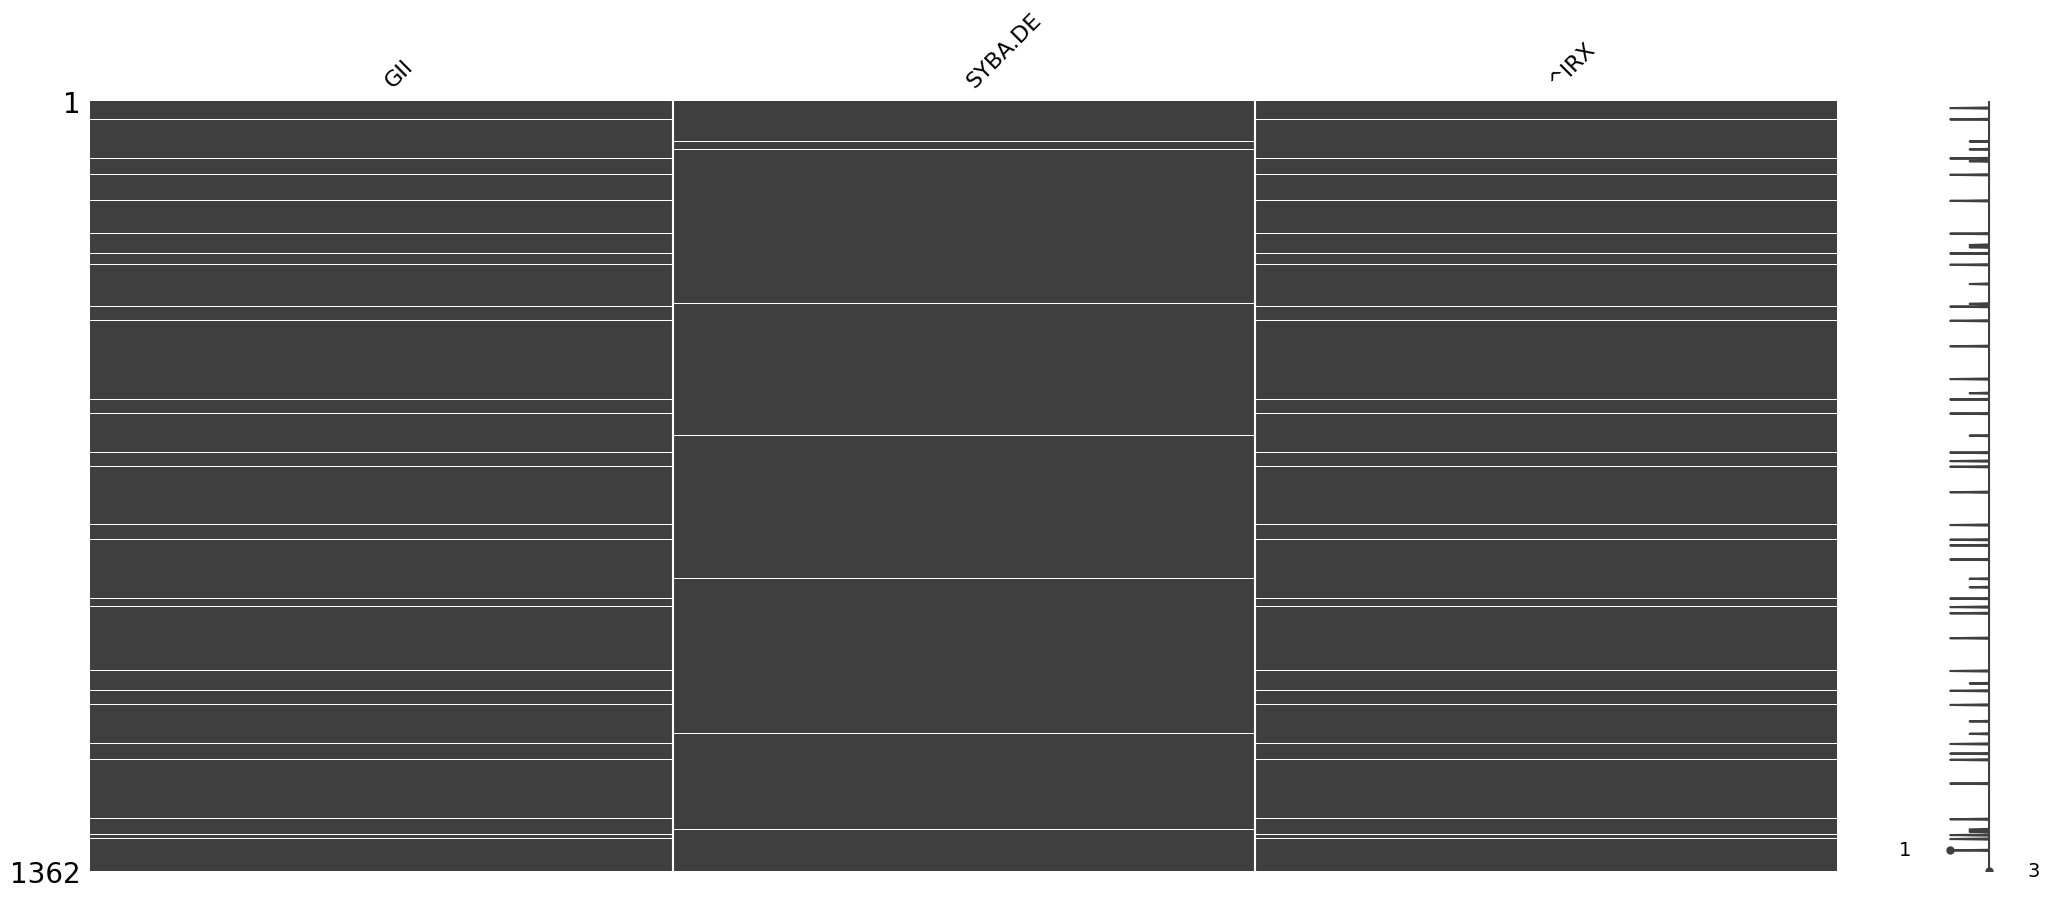

In [17]:
# Descarga Indices de cada fondo
indices = ['GII','SYBA.DE','^IRX']
start = '2020-01-01'
end = '2025-04-10'

datos_indices = yf.download(indices, start=start, end=end, auto_adjust=True)['Close']

# Limpieza indices
mno.matrix(datos_indices)

<Axes: >

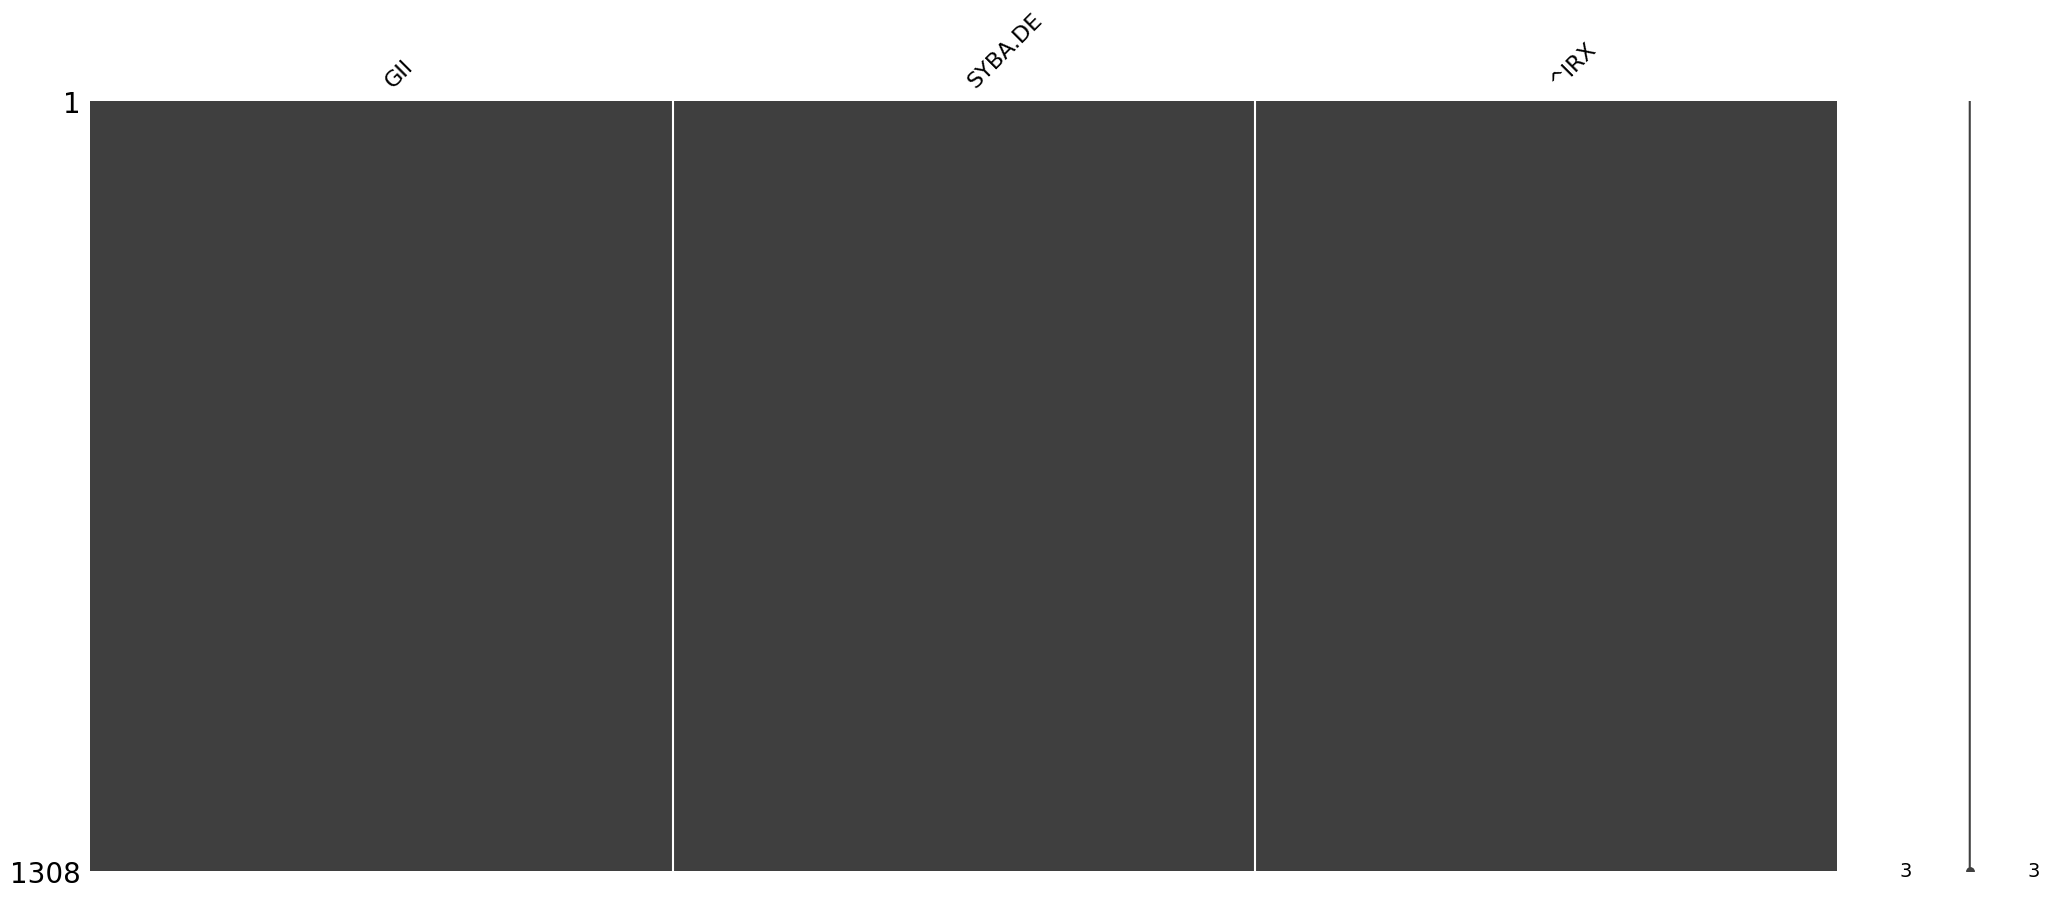

In [18]:
datos_indices.dropna(axis=0, how="any", inplace=True)
mno.matrix(datos_indices)

In [19]:
# Factores de Fama y French semanales
file_path = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_weekly_CSV.zip'

ff_factores = pd.read_csv(file_path, skiprows=4, index_col=0, parse_dates=True)


ff_factores = ff_factores.dropna()
ff_factores.index = pd.to_datetime(ff_factores.index, format='%Y%m%d')

ff_factores = ff_factores / 100
datos_ff_factores = ff_factores.loc['2020-01-01':'2025-04-10']
datos_ff_factores

,Mkt-RF,SMB,HML,RF
2020-01-03,-0.0012,-0.0032,0.0034,0.00032
2020-01-10,0.0094,-0.0095,-0.0228,0.00032
2020-01-17,0.0200,0.0064,-0.0133,0.00032
2020-01-24,-0.0114,-0.0126,-0.0102,0.00032
2020-01-31,-0.0206,-0.0108,-0.0146,0.00032
...,...,...,...,...
2024-11-29,0.0095,0.0057,-0.0062,0.00099
2024-12-06,0.0104,-0.0020,-0.0303,0.00092
2024-12-13,-0.0093,-0.0080,-0.0016,0.00092
2024-12-20,-0.0228,-0.0152,-0.0142,0.00092


In [20]:
# Pasar datos de diario a semanal para evitar reducir el ruido de los datos
datos_fondos.index = pd.to_datetime(datos_fondos.index)
datos_fondos_sem = datos_fondos.resample("W-WED").first()
datos_indices_sem = datos_indices.resample("W-WED").first()
datos_ff_factores_sem = datos_ff_factores.resample("W-WED").first()

datos_fondos_sem , datos_indices_sem , datos_ff_factores_sem

(            IE00BNQ4RL64  LU0570466788  LU0945454980
 date                                                
 2020-01-08       14.7316       105.910        104.99
 2020-01-15       14.6868       105.940        105.03
 2020-01-22       14.9735       106.000        105.06
 2020-01-29       15.1159       106.070        105.10
 2020-02-05       15.0289       106.100        105.13
 ...                  ...           ...           ...
 2025-03-19       19.4222       124.211        118.92
 2025-03-26       20.0987       124.341        119.00
 2025-04-02       20.0502       124.483        119.10
 2025-04-09       20.5360       124.517        119.19
 2025-04-16       19.5158       124.547        119.28
 
 [276 rows x 3 columns],
 Ticker            GII    SYBA.DE   ^IRX
 Date                                   
 2020-01-08  47.451878  60.308514  1.495
 2020-01-15  47.529804  60.213577  1.500
 2020-01-22  48.733418  60.342697  1.518
 2020-01-29  48.690128  60.728142  1.515
 2020-02-05  48.681465  6

<Axes: >

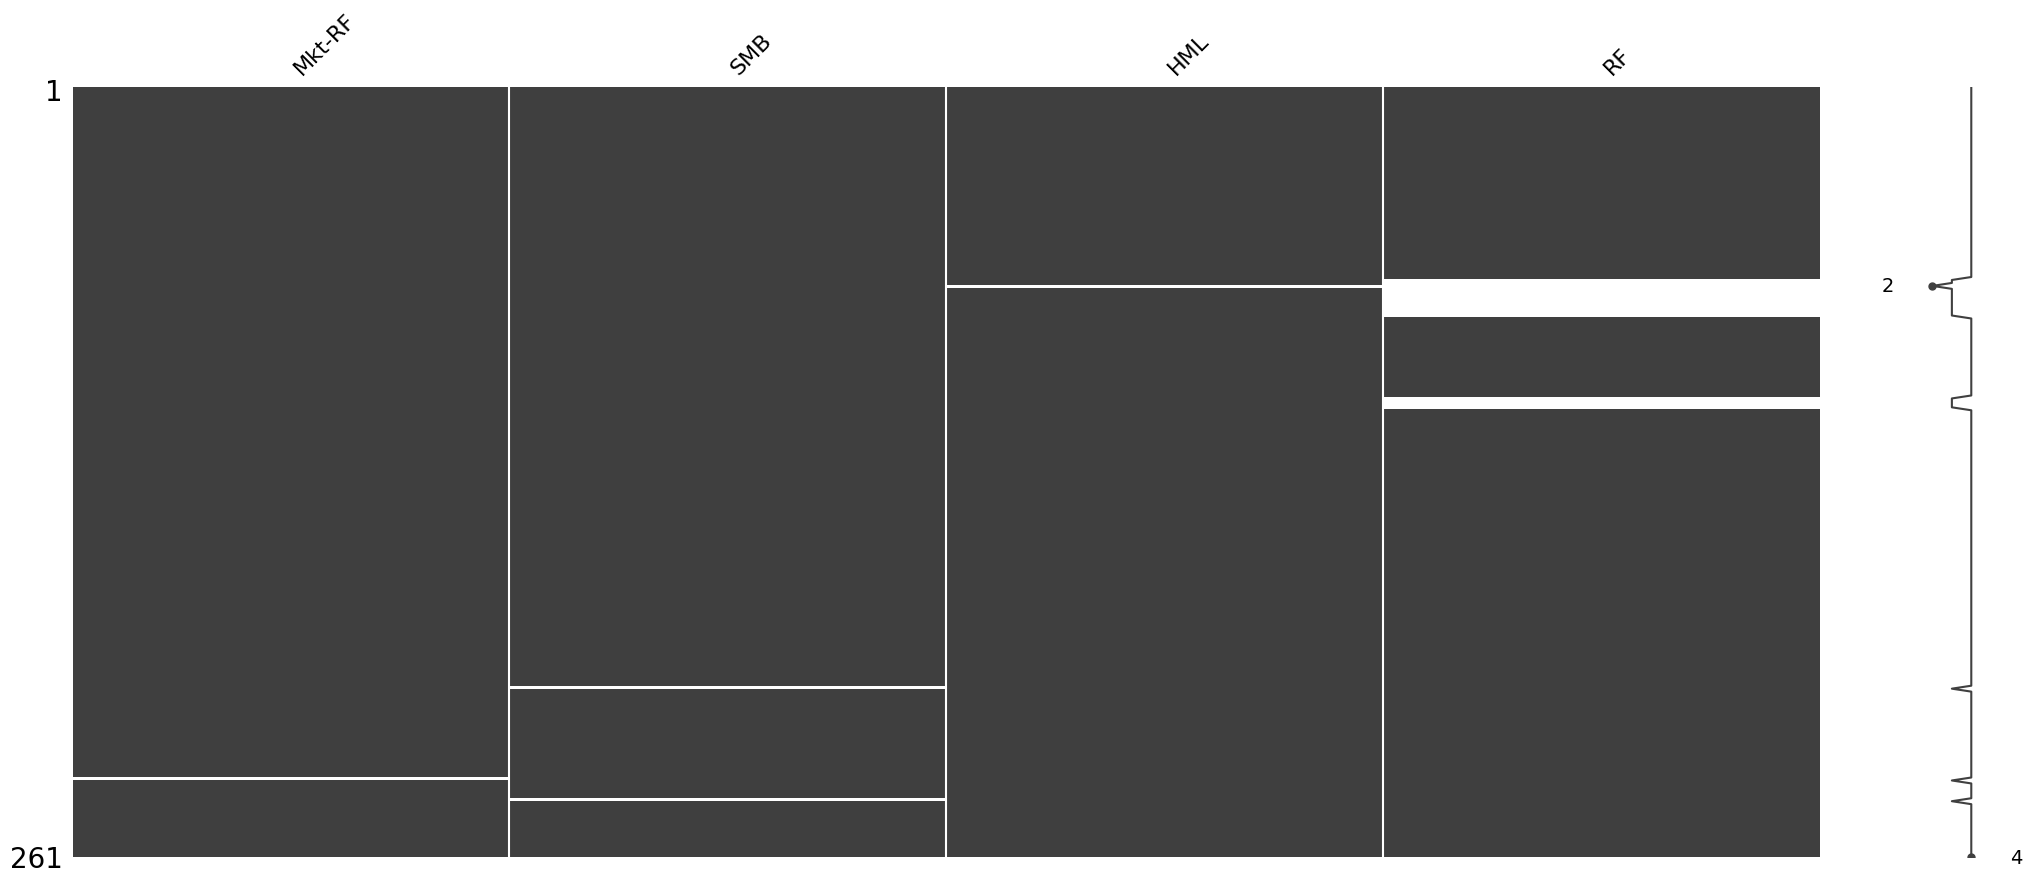

In [21]:
# Limpiamos los datos de precios semanales.
mask = datos_ff_factores_sem == 0 # True/False si el dato es igual a 0
datos_ff_factores_sem[mask] = np.nan  # 0 = NaN, para poder limpiar
mno.matrix(datos_ff_factores_sem)

<Axes: >

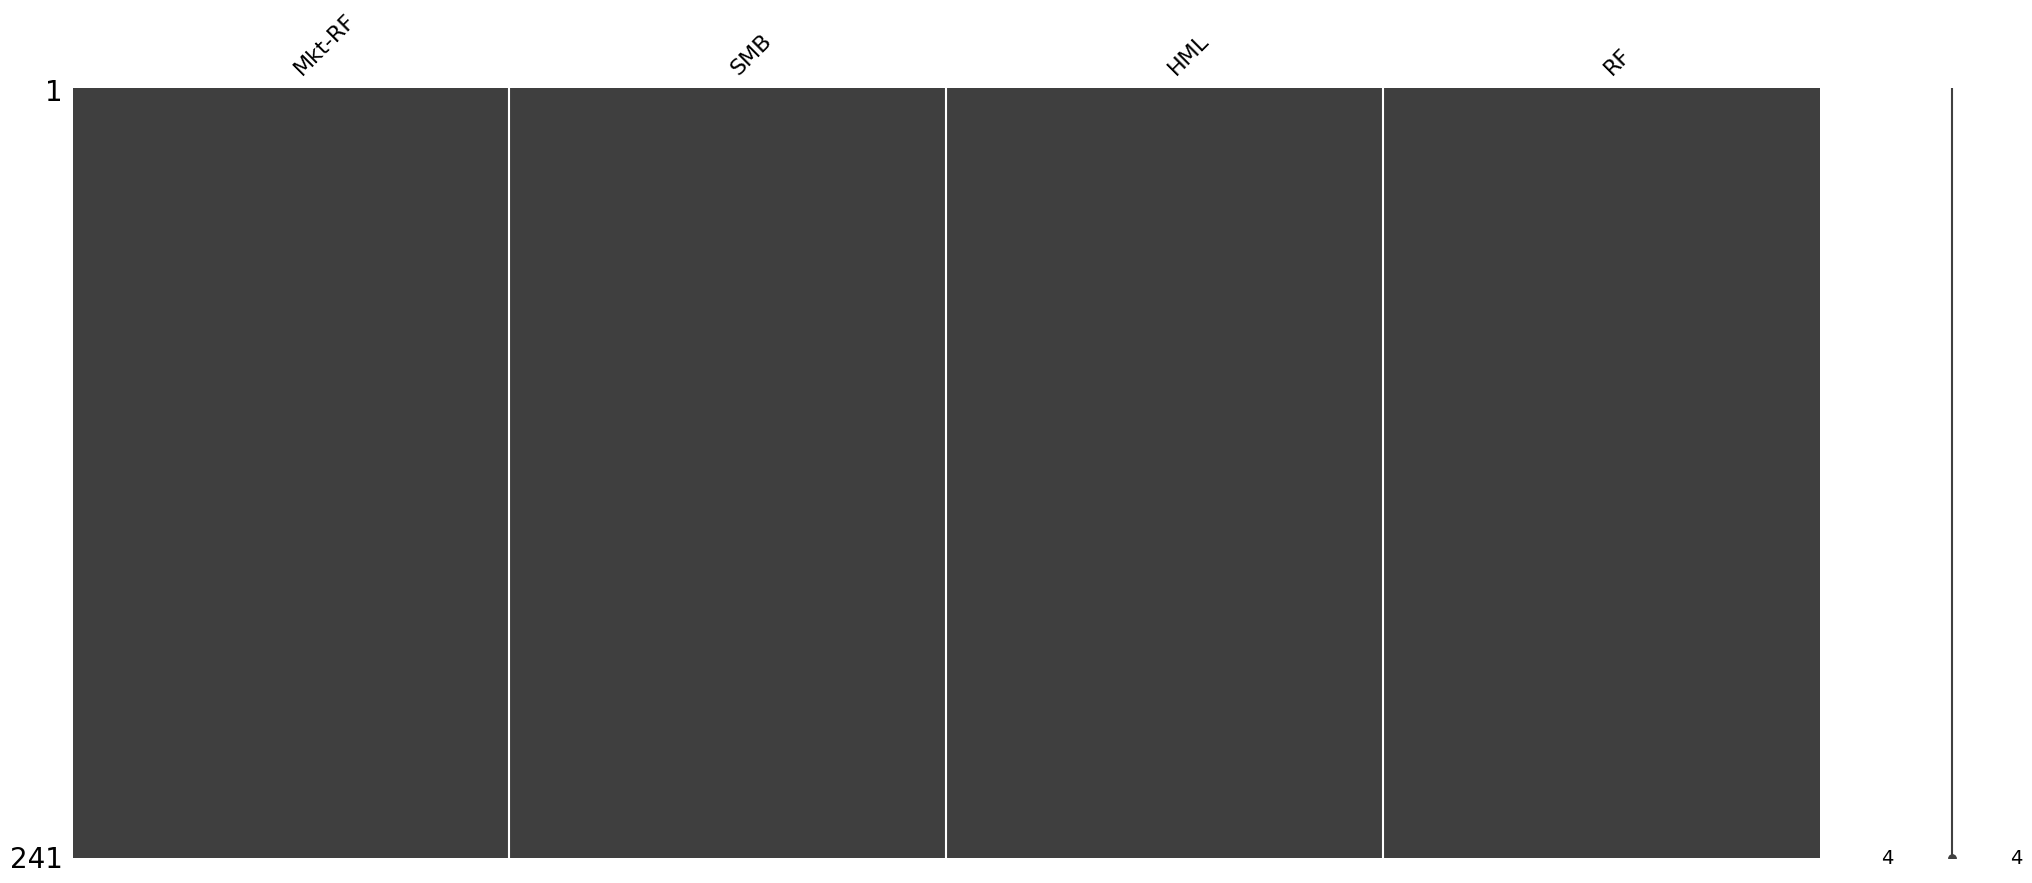

In [22]:
datos_ff_factores_sem.dropna(axis=0, how="any", inplace=True)
mno.matrix(datos_ff_factores_sem)

In [23]:
# Eliminar ceros y NaN antes de aplicar log
datos_fondos_sem = datos_fondos_sem.replace(0, np.nan).dropna()
datos_indices_sem = datos_indices_sem.replace(0, np.nan).dropna()
datos_ff_factores_sem = datos_ff_factores_sem.replace(0, np.nan).dropna()

# Evitar datos cercanos a 0 (Daba error sin ello)
datos_fondos_sem = datos_fondos_sem.clip(lower=1e-8)
datos_indices_sem = datos_indices_sem.clip(lower=1e-8)
datos_ff_factores_sem = datos_ff_factores_sem.clip(lower=1e-8)

# Ahora calcular retornos
retornos_datos_fondos_sem = np.log(datos_fondos_sem).diff().dropna()
retornos_datos_indices_sem = np.log(datos_indices_sem).diff().dropna()
retornos_datos_ff_factores_sem = np.log(datos_ff_factores_sem).diff().dropna()

In [24]:
cartera = pd.concat([retornos_datos_fondos_sem, retornos_datos_indices_sem, retornos_datos_ff_factores_sem.loc[:, ["Mkt-RF", "RF"]]],
    axis=1, join="inner")
cartera.columns

Index(['IE00BNQ4RL64', 'LU0570466788', 'LU0945454980', 'GII', 'SYBA.DE',
       '^IRX', 'Mkt-RF', 'RF'],
      dtype='object')

In [25]:
# Pesos de los fondos en la cartera
ListaISIN = ['IE00BNQ4RL64','LU0570466788','LU0945454980'] # Crear una lista de los ISIN selccionados
pesos = np.ones(len(ListaISIN)) / len(ListaISIN)  # Hacer pesos equiponderados
pesos

array([0.33333333, 0.33333333, 0.33333333])

In [26]:
# Periodos
periodo = cartera["2020-01-01":"2025-04-10"]
bear_market = cartera.loc["2020-01-01":"2022-12-31"]
bull_market = cartera.loc["2023-01-01":"2025-04-10"]

In [27]:
# Bear Market
bear_market_data = []
for ticker in retornos_datos_fondos_sem.columns:
    Y = bear_market.loc[:, ticker] - bear_market.loc[:, "RF"] # Retornos ajustados por riesgo
    X = bear_market.loc[:, ticker]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()

    bear_market_data.append({ # Guardar datos
        "Ticker": ticker,
        "Alpha": model.params["const"],
        "Beta": model.params[ticker],
        "R2": model.rsquared,
        "Alpha-P-value": model.pvalues["const"],
        "Beta-P-value": model.pvalues[ticker],})

bear_market_data_df = pd.DataFrame(bear_market_data)
print(f'Durante el periodo Bear Market (2020-2022) los fondos cuenta con la siguiente información: \n{bear_market_data_df}')

Durante el periodo Bear Market (2020-2022) los fondos cuenta con la siguiente información: 
         Ticker     Alpha        Beta        R2  Alpha-P-value  Beta-P-value
0  IE00BNQ4RL64 -0.006776   -0.173655  0.000231       0.825817      0.859673
1  LU0570466788 -0.007353    4.353507  0.000673       0.812527      0.762634
2  LU0945454980  0.006452 -102.871885  0.004820       0.853439      0.418432


In [28]:
# Seleccionar los tickers del df anterior para crear la cartera con las fechas necesarias
tickers = bear_market_data_df['Ticker']
bear_market.loc[:, tickers]

,IE00BNQ4RL64,LU0570466788,LU0945454980
2020-01-15,-0.003046,0.000283,0.000381
2020-01-22,0.019333,0.000566,0.000286
2020-01-29,0.009465,0.000660,0.000381
2020-02-05,-0.005772,0.000283,0.000285
2020-02-12,0.012629,0.000660,0.000285
...,...,...,...
2022-11-30,0.037276,0.002729,0.000939
2022-12-07,0.008719,0.002109,0.000563
2022-12-14,-0.016698,0.000677,0.000844
2022-12-21,0.000038,0.001187,0.000750


In [29]:
# Ex-Ante
retorno_cartera_bear = bear_market.loc[:, tickers].mean()
retorno_esperado_bear = retorno_cartera_bear @ pesos
retorno_cartera_bear , retorno_esperado_bear

(IE00BNQ4RL64    0.000111
 LU0570466788    0.000133
 LU0945454980    0.000129
 dtype: float64,
 np.float64(0.00012440129941821212))

In [30]:
 # Ex-post
retorno_sem_bear = bear_market.loc[:, tickers] @ pesos
retorno_sem_bear

,0
2020-01-15,-0.000794
2020-01-22,0.006728
2020-01-29,0.003502
2020-02-05,-0.001735
2020-02-12,0.004525
...,...
2022-11-30,0.013648
2022-12-07,0.003797
2022-12-14,-0.005059
2022-12-21,0.000658


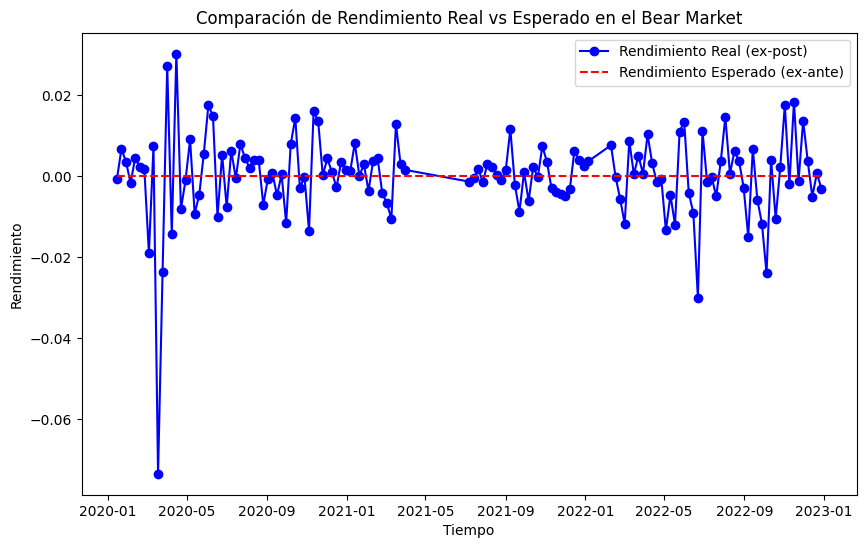

In [31]:
retorno_esperado_series = [retorno_esperado_bear] * len(retorno_sem_bear)

plt.figure(figsize=(10, 6))
plt.plot(retorno_sem_bear.index, retorno_sem_bear, label='Rendimiento Real (ex-post)', color='blue', marker='o')
plt.plot(retorno_sem_bear.index, retorno_esperado_series, label='Rendimiento Esperado (ex-ante)', color='red', linestyle='--')
plt.title('Comparación de Rendimiento Real vs Esperado en el Bear Market')
plt.xlabel('Tiempo')
plt.ylabel('Rendimiento')
plt.legend()
plt.show()

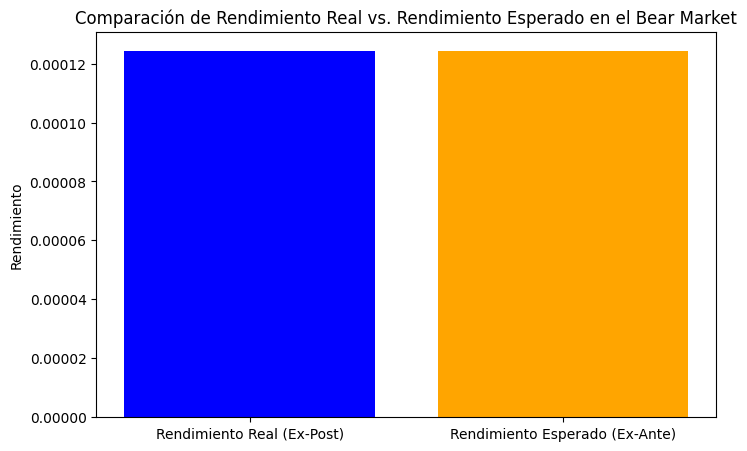

In [32]:
labels = ['Rendimiento Real (Ex-Post)', 'Rendimiento Esperado (Ex-Ante)']
valores = [retorno_sem_bear.mean(), retorno_esperado_bear]  # Usamos la media del rendimiento semanal para la comparación

plt.figure(figsize=(8, 5))
plt.bar(labels, valores, color=['blue', 'orange'])
plt.ylabel('Rendimiento')
plt.title('Comparación de Rendimiento Real vs. Rendimiento Esperado en el Bear Market')
plt.show()

In [33]:
# Bull Market
bull_market_data = []
for ticker in retornos_datos_fondos_sem.columns:
    Y = bull_market.loc[:, ticker] - bull_market.loc[:, "RF"] # Retornos ajustados por riesgo
    X = bull_market[ticker]
    X = sm.add_constant(X)

    model = sm.OLS(Y, X).fit()

    bull_market_data.append({ # Guardar datos
        "Ticker": ticker,
        "Alpha": model.params["const"],
        "Beta": model.params[ticker],
        "R2": model.rsquared,
        "Alpha-P-value": model.pvalues["const"],
        "Beta-P-value": model.pvalues[ticker],})

bull_market_data_df = pd.DataFrame(bull_market_data)
print(f'Durante el periodo Bull Market (2023-2025) los fondos cuenta con la siguiente información: \n{bull_market_data_df}')

Durante el periodo Bull Market (2023-2025) los fondos cuenta con la siguiente información: 
         Ticker     Alpha       Beta        R2  Alpha-P-value  Beta-P-value
0  IE00BNQ4RL64 -0.001442   1.316798  0.273517       0.697830  1.709854e-08
1  LU0570466788 -0.001447   1.356397  0.001545       0.798140  6.948489e-01
2  LU0945454980  0.009383 -10.151215  0.000863       0.772795  7.694874e-01


In [34]:
tickers = bull_market_data_df['Ticker']
bull_market.loc[:, tickers]

,IE00BNQ4RL64,LU0570466788,LU0945454980
2023-01-04,0.010684,0.001341,0.000842
2023-01-11,-0.009428,0.000083,0.000841
2023-01-18,0.039030,0.002279,0.000840
2023-01-25,-0.011467,0.002210,0.000933
2023-02-01,0.014947,0.001911,0.000839
...,...,...,...
2024-12-04,0.010253,0.001144,0.001022
2024-12-11,-0.017375,0.001200,0.000595
2024-12-18,-0.032852,0.000987,0.000850
2024-12-25,-0.036405,0.000888,0.000849


In [35]:
retorno_sem_bull = bull_market.loc[:, tickers] @ pesos
retorno_sem_bull  # Ex-post

,0
2023-01-04,0.004289
2023-01-11,-0.002835
2023-01-18,0.014050
2023-01-25,-0.002775
2023-02-01,0.005899
...,...
2024-12-04,0.004139
2024-12-11,-0.005193
2024-12-18,-0.010339
2024-12-25,-0.011556


In [36]:
# Ex-Ante
retorno_cartera_bull = bull_market.loc[:, tickers].mean()
retorno_esperado_bull = retorno_cartera_bull @ pesos
retorno_cartera_bull , retorno_esperado_bull

(IE00BNQ4RL64    0.001367
 LU0570466788    0.001227
 LU0945454980    0.000932
 dtype: float64,
 np.float64(0.0011751178384616131))

In [37]:
 # Ex-post
retorno_sem_bull = bull_market.loc[:, tickers] @ pesos
retorno_sem_bull

,0
2023-01-04,0.004289
2023-01-11,-0.002835
2023-01-18,0.014050
2023-01-25,-0.002775
2023-02-01,0.005899
...,...
2024-12-04,0.004139
2024-12-11,-0.005193
2024-12-18,-0.010339
2024-12-25,-0.011556


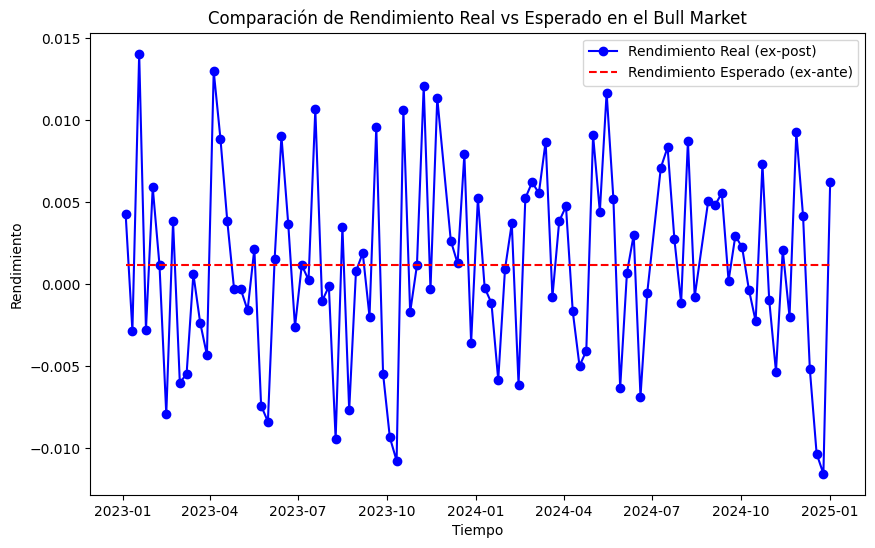

In [38]:
retorno_esperado_series = [retorno_esperado_bull] * len(retorno_sem_bull)

plt.figure(figsize=(10, 6))
plt.plot(retorno_sem_bull.index, retorno_sem_bull, label='Rendimiento Real (ex-post)', color='blue', marker='o')
plt.plot(retorno_sem_bull.index, retorno_esperado_series, label='Rendimiento Esperado (ex-ante)', color='red', linestyle='--')
plt.title('Comparación de Rendimiento Real vs Esperado en el Bull Market')
plt.xlabel('Tiempo')
plt.ylabel('Rendimiento')
plt.legend()
plt.show()

In [39]:
# Explicación de los retornos del fondo con su índice en los distintos periodos
Y = bear_market.loc[:,'IE00BNQ4RL64']
X = bear_market.loc[:, "GII"]
X = sm.add_constant(X)
model_bear = sm.OLS(Y, X).fit()

Y = bull_market.loc[:,'IE00BNQ4RL64']
X = bull_market.loc[:, "GII"]
X = sm.add_constant(X)
model_bull = sm.OLS(Y, X).fit()

print(f'Resumen del modelo en el mercado bajista:\n{model_bear.summary()}\nResumen del modelo en el mercado alcista:{model_bull.summary()}')

Resumen del modelo en el mercado bajista:
                            OLS Regression Results                            
Dep. Variable:           IE00BNQ4RL64   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1175.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           8.80e-69
Time:                        11:48:20   Log-Likelihood:                 438.38
No. Observations:                 138   AIC:                            -872.8
Df Residuals:                     136   BIC:                            -866.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

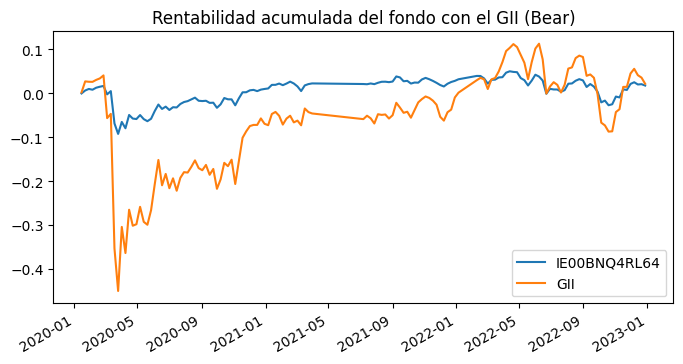

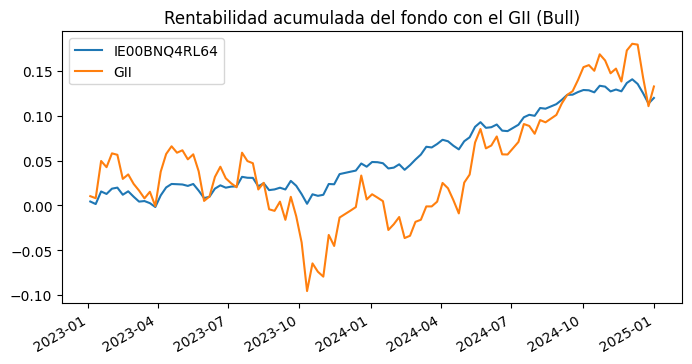

In [40]:
# Graficar
plt.figure()
retorno_sem_bear.cumsum().plot(figsize=(8, 4), label="IE00BNQ4RL64")
bear_market.loc[:, "GII"].cumsum().plot(label="GII")
plt.title("Rentabilidad acumulada del fondo con el GII (Bear)")
plt.legend()
plt.show()

plt.figure()
retorno_sem_bull.cumsum().plot(figsize=(8, 4), label="IE00BNQ4RL64")
bull_market.loc[:, "GII"].cumsum().plot(label="GII")
plt.title("Rentabilidad acumulada del fondo con el GII (Bull)")
plt.legend()
plt.show()

In [41]:
# Explicación de los retornos del fondo con su índice.
Y = bear_market.loc[:,'LU0570466788']
X = bear_market.loc[:, "SYBA.DE"]
X = sm.add_constant(X)
model_bear = sm.OLS(Y, X).fit()

Y = bull_market.loc[:,'LU0570466788']
X = bull_market.loc[:, "SYBA.DE"]
X = sm.add_constant(X)
model_bull = sm.OLS(Y, X).fit()

print(f'Resumen del modelo en el mercado bajista:\n{model_bear.summary()}\nResumen del modelo en el mercado alcista:{model_bull.summary()}')

Resumen del modelo en el mercado bajista:
                            OLS Regression Results                            
Dep. Variable:           LU0570466788   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     26.95
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           7.42e-07
Time:                        11:48:20   Log-Likelihood:                 664.49
No. Observations:                 138   AIC:                            -1325.
Df Residuals:                     136   BIC:                            -1319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

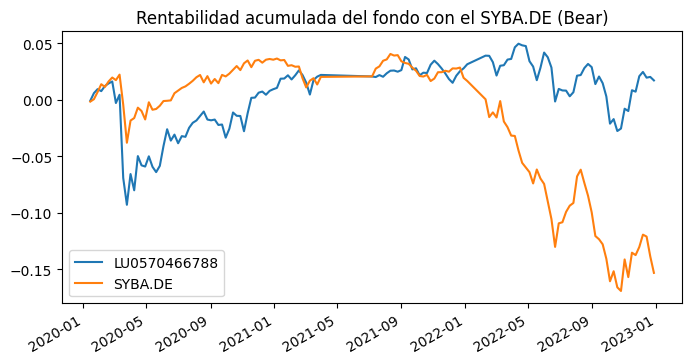

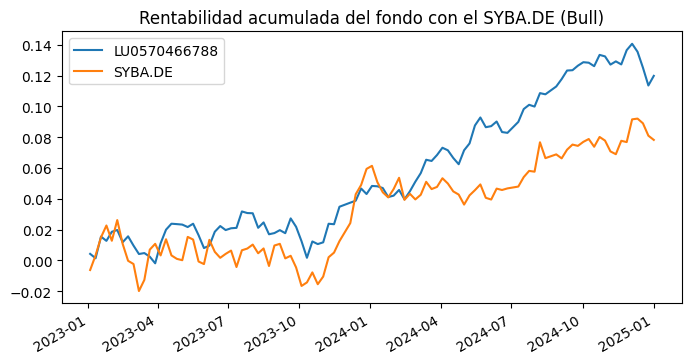

In [42]:
plt.figure()
retorno_sem_bear.cumsum().plot(figsize=(8, 4), label="LU0570466788")
bear_market.loc[:, "SYBA.DE"].cumsum().plot(label="SYBA.DE")
plt.title("Rentabilidad acumulada del fondo con el SYBA.DE (Bear)")
plt.legend()
plt.show()

plt.figure()
retorno_sem_bull.cumsum().plot(figsize=(8, 4), label="LU0570466788")
bull_market.loc[:, "SYBA.DE"].cumsum().plot(label="SYBA.DE")
plt.title("Rentabilidad acumulada del fondo con el SYBA.DE (Bull)")
plt.legend()
plt.show()

In [43]:
# Explicación de los retornos del fondo con su índice.
Y = bear_market.loc[:,'LU0945454980']
X = bear_market.loc[:, "^IRX"]
X = sm.add_constant(X)
model_bear = sm.OLS(Y, X).fit()

Y = bull_market.loc[:,'LU0945454980']
X = bull_market.loc[:, "^IRX"]
X = sm.add_constant(X)
model_bull = sm.OLS(Y, X).fit()

print(f'Resumen del modelo en el mercado bajista:\n{model_bear.summary()}\nResumen del modelo en el mercado alcista:{model_bull.summary()}')

Resumen del modelo en el mercado bajista:
                            OLS Regression Results                            
Dep. Variable:           LU0945454980   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     4.357
Date:                Sat, 19 Apr 2025   Prob (F-statistic):             0.0387
Time:                        11:48:21   Log-Likelihood:                 954.79
No. Observations:                 138   AIC:                            -1906.
Df Residuals:                     136   BIC:                            -1900.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

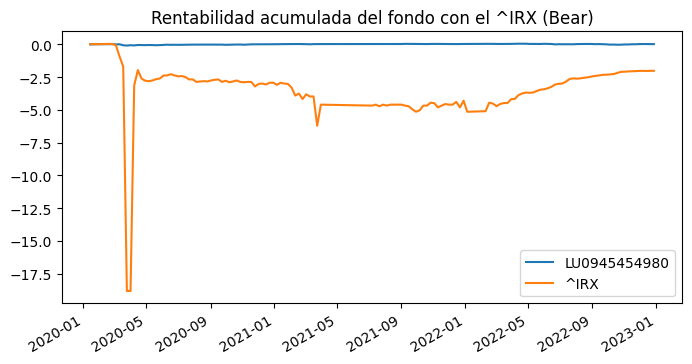

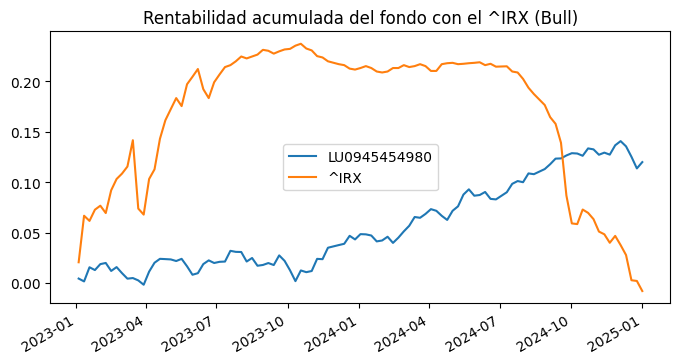

In [44]:
plt.figure()
retorno_sem_bear.cumsum().plot(figsize=(8, 4), label="LU0945454980")
bear_market.loc[:, "^IRX"].cumsum().plot(label="^IRX")
plt.title("Rentabilidad acumulada del fondo con el ^IRX (Bear)")
plt.legend()
plt.show()

plt.figure()
retorno_sem_bull.cumsum().plot(figsize=(8, 4), label="LU0945454980")
bull_market.loc[:, "^IRX"].cumsum().plot(label="^IRX")
plt.title("Rentabilidad acumulada del fondo con el ^IRX (Bull)")
plt.legend()
plt.show()